In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [3]:
transform_characteristics = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

The dataloader is compoosed of 6 batches, each of them of size 32 making a total of: 192, which is enough for storing the 179 images that we have in the positive dataset

In [4]:
print(len(dataloader))

6


In [5]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0078) tensor(1.)


The problem with the above is that we expected the min value to be 0 according to a previous example.

The following, is a way of formatting the image to be able to show them:

Converting the images to numpy to be able to show them

In [10]:
imgs = images.detach().numpy()
# imgs = images.numpy()     #We could also use this command to convert it to numpy array. Not sure about the differences
print(type(imgs))

<class 'numpy.ndarray'>


In [11]:
single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))

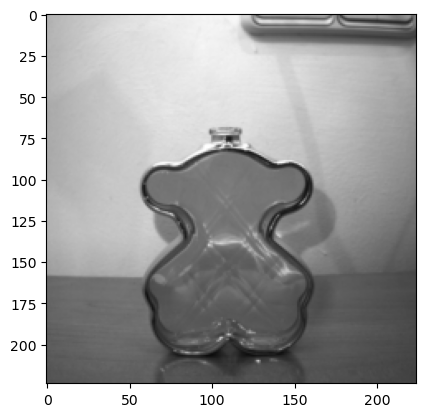

In [12]:
plt.imshow(new_img_to_show)

In [13]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        # 32, 3, 224, 224
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> N, 110, 44, 44
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # -> N, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # -> N, 450, 1, 1
        )
        
        # N , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # -> 32, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # N, 3, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [15]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [12]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in dataloader:     # This iterates over the batches of images.
        
        # Forward pass
        recon = model(img)          # The entire batch of images is passed to the model
        loss = criterion(recon, img)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0259
Epoch:2, Loss:0.0102
Epoch:3, Loss:0.0079
Epoch:4, Loss:0.0072
Epoch:5, Loss:0.0066
Epoch:6, Loss:0.0059
Epoch:7, Loss:0.0065
Epoch:8, Loss:0.0058
Epoch:9, Loss:0.0057
Epoch:10, Loss:0.0058


Saving and loading a model

In [16]:
filepath = "../../../BottlesAnomalies_TFM/models/PytorchModel1"


In [ ]:
torch.save(model.state_dict(), filepath)

In [17]:
# For loading the model 
model.load_state_dict(torch.load(filepath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [18]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Original Images


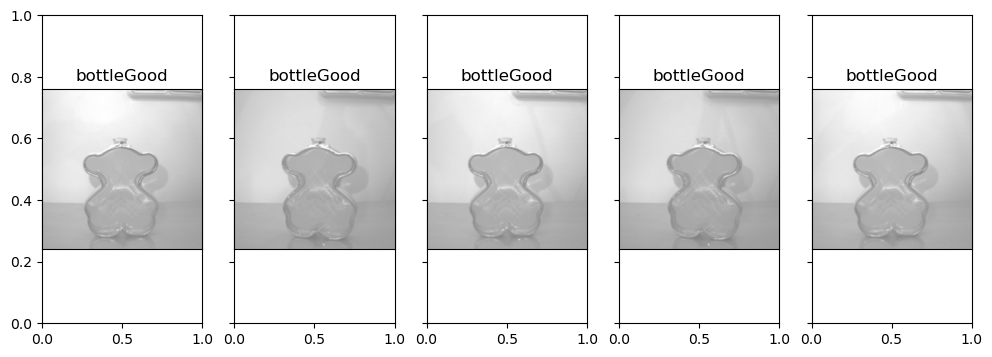

Reconstructed Images


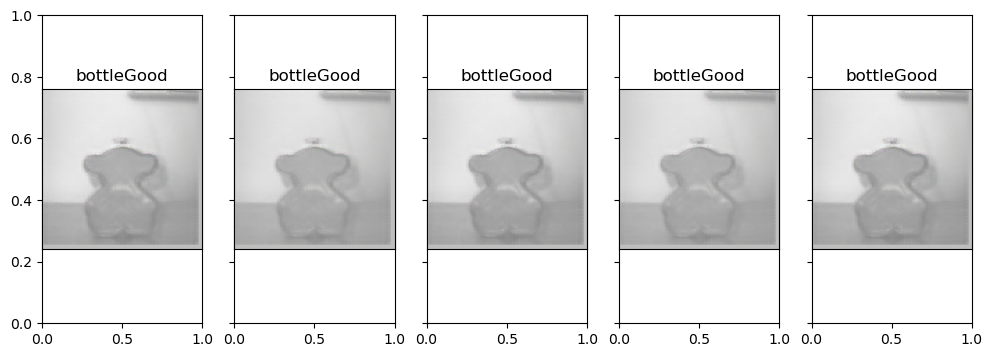

In [19]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)

#Sample outputs
output = model(images)

images = images.numpy()

output = output.view(32, 3, 224, 224)
output = output.detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

In [21]:
print(type(output))

<class 'numpy.ndarray'>


Computing the error between the orinigal and reconstructed image.

In [22]:
model.evaluate()

MSELoss()

In [23]:
loss.item()

NameError: name 'loss' is not defined